# Проект: классификация

In [976]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [977]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [978]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [979]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [980]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [981]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance'] = df['balance'].apply(lambda x: str(x).replace('$', ''))
df['balance'] = df['balance'].apply(lambda x: x.replace(',', '.').replace(' ',''))
df['balance'] = df['balance'].apply(lambda x: float(x))
df['balance']

0        2343.0
1          45.0
2        1270.0
3        2476.0
4         184.0
          ...  
11157       1.0
11158     733.0
11159      29.0
11160       0.0
11161       0.0
Name: balance, Length: 11162, dtype: float64

### Задание 4

In [982]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
median_balance = df['balance'].median()
display(f'Median balance: {median_balance}')
df['balance'].fillna(median_balance, inplace=True)
df['balance'].isna().sum()

'Median balance: 550.0'

0

In [983]:
round(df['balance'].mean(),3)

1526.936

### Задание 5

In [946]:
df['education'].value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [985]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
education_mode = df['education'].mode()
df['education'] = df['education'].apply(lambda x: education_mode[0] if x == 'unknown' else x)

job_mode = df['job'].mode()
df['job'] = df['job'].apply(lambda x: job_mode[0] if x == 'unknown' else x)

### Задание 6

In [987]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    df_cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return df_cleaned, lower_bound, upper_bound

df_cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')
print(f'Cleaned: {df_cleaned.shape[0]}')
df_cleaned.shape[0]

Lower bound: -2241.0
Upper bound: 4063.0
Cleaned: 10105


10105

## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64

Text(0.5, 1.0, 'Сбалансированность классов')

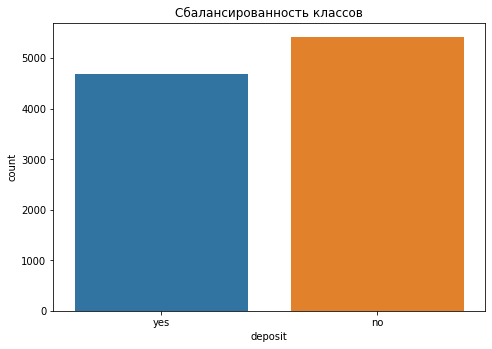

In [988]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df = df_cleaned
display(df['deposit'].value_counts())

fig = plt.figure(figsize=(6,4))
axes = fig.add_axes([0, 0, 1, 1])
sns.countplot(data=df, x='deposit')
axes.set_title('Сбалансированность классов')

### Задания 2 и 3

In [989]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


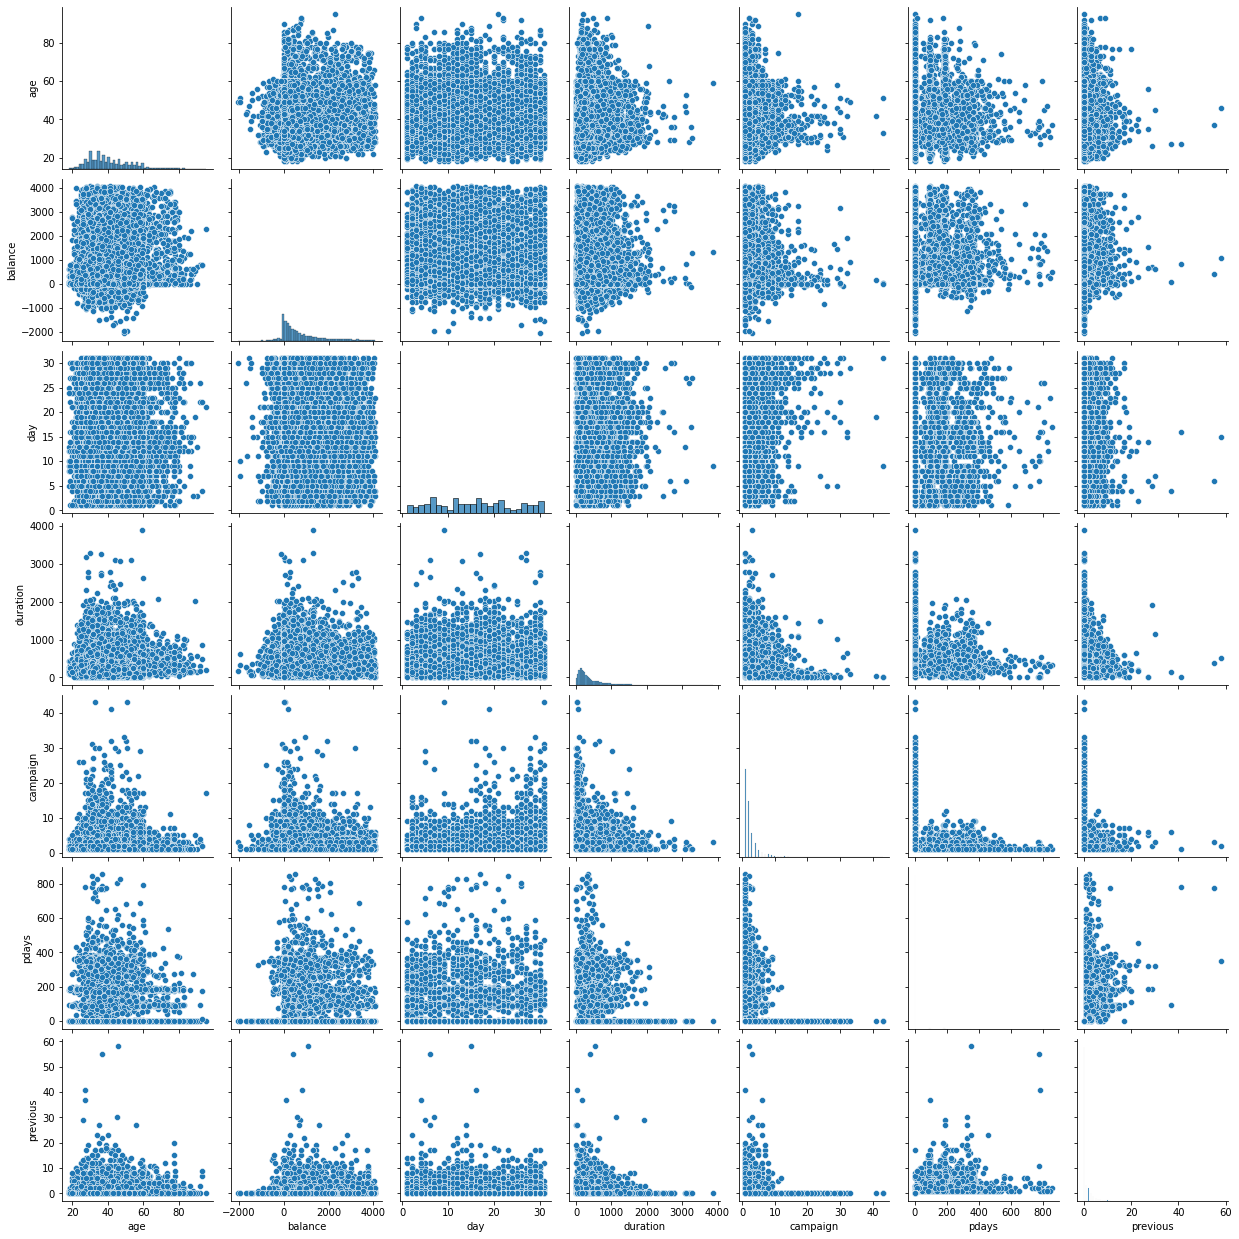

In [990]:
num_features = ['age','balance','day','duration','campaign','pdays','previous']
sns.pairplot(data=df[num_features])

### Задания 4 и 5

In [991]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


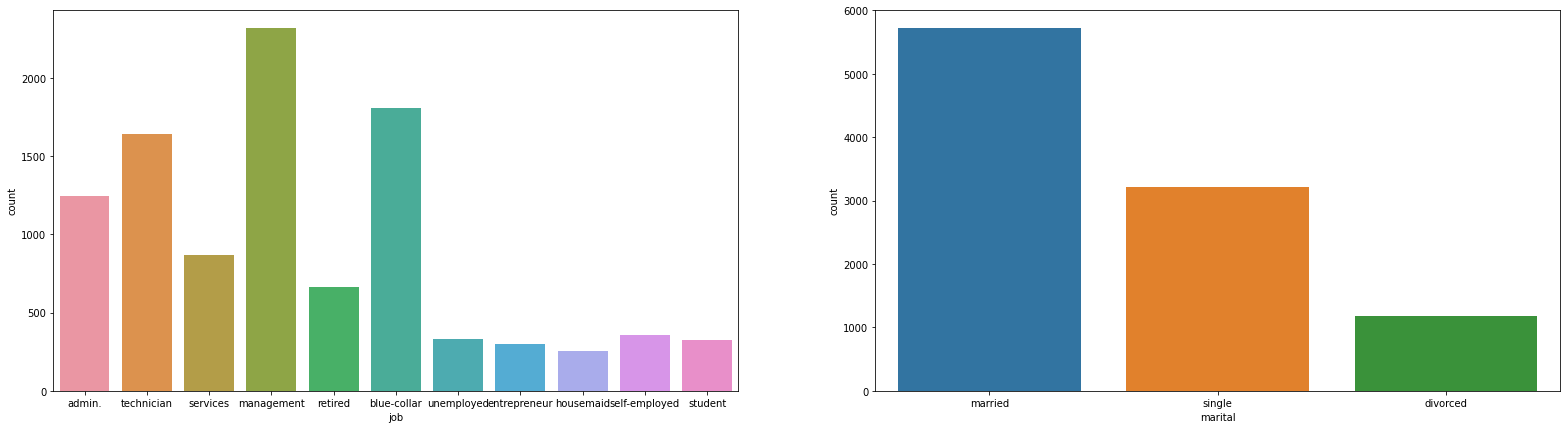

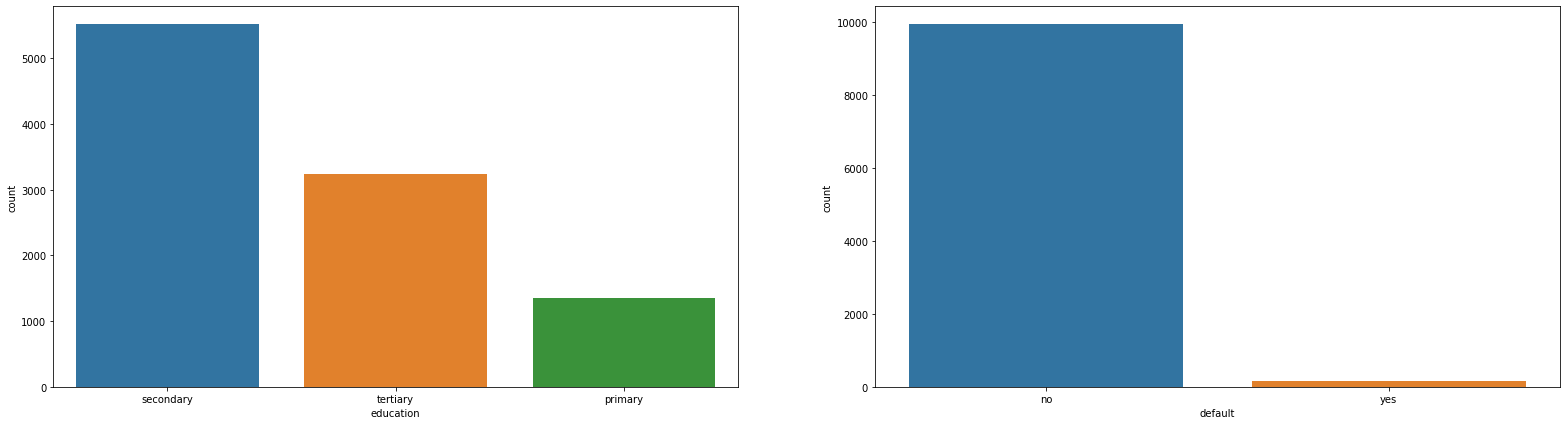

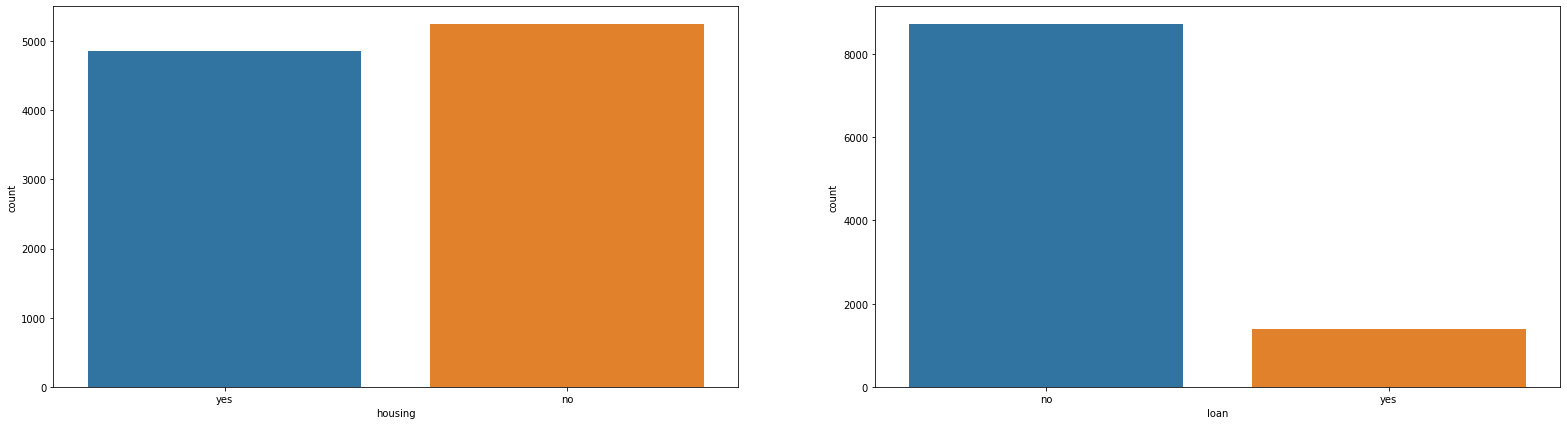

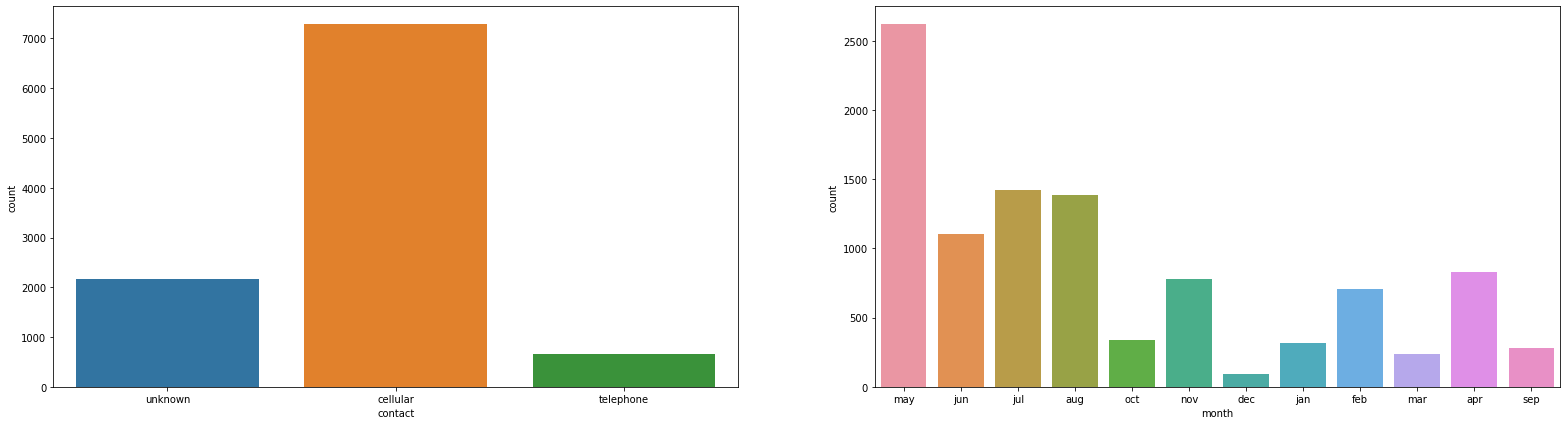

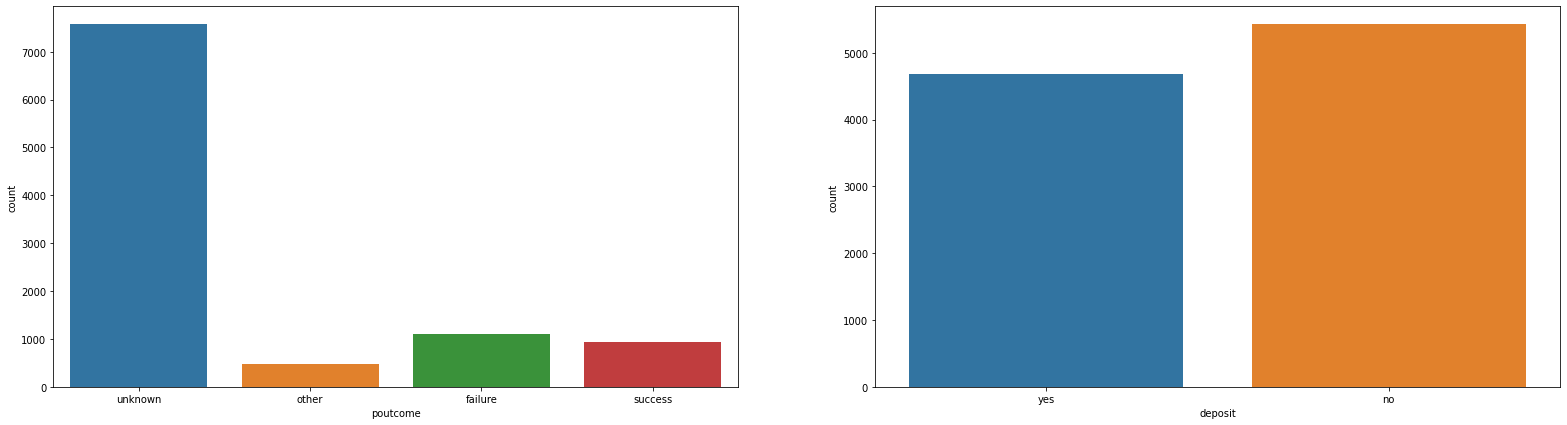

In [992]:
#постройте визуализации, иллюстрирующие результаты
fig, ax = plt.subplots(1, 2, figsize=(27,7))
sns.countplot(df['job'], ax=ax[0])
sns.countplot(df['marital'], ax=ax[1])
fig.show()

fig2, ax = plt.subplots(1, 2, figsize=(27,7))
sns.countplot(df['education'], ax=ax[0])
sns.countplot(df['default'], ax=ax[1])
fig2.show()

fig3, ax = plt.subplots(1, 2, figsize=(27,7))
sns.countplot(df['housing'], ax=ax[0])
sns.countplot(df['loan'], ax=ax[1])
fig3.show()

fig4, ax = plt.subplots(1, 2, figsize=(27,7))
sns.countplot(df['contact'], ax=ax[0])
sns.countplot(df['month'], ax=ax[1])
fig4.show()

fig5, ax = plt.subplots(1, 2, figsize=(27,7))
sns.countplot(df['poutcome'], ax=ax[0])
sns.countplot(df['deposit'], ax=ax[1])
fig5.show()

### Задание 6

In [995]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
grouped_poutcome = df.groupby(by='poutcome')['deposit'].value_counts().unstack()
display(grouped_poutcome)

import plotly
import plotly.express as px
print(plotly.__version__)

fig = px.bar(
    grouped_poutcome,
    height=500, 
    width=900,
    title='Deposit and dpoutcome')
fig.show()

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


5.8.0


### Задание 7

In [996]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_grouped = df.groupby(by='month')['deposit'].value_counts().unstack()
df_grouped

deposit,no,yes
month,,
apr,317,513
aug,775,610
dec,9,84
feb,323,386
jan,194,125
jul,836,582
jun,606,498
mar,24,213
may,1776,841


In [997]:
month_dict = {}
for i in df.month:
    month_dict[i] = round(len(df[(df.month == i) & (df.deposit == 'no')])/len(df[(df.month == i)]),2)


In [998]:
month_dict 

{'may': 0.68,
 'jun': 0.55,
 'jul': 0.59,
 'aug': 0.56,
 'oct': 0.19,
 'nov': 0.58,
 'dec': 0.1,
 'jan': 0.61,
 'feb': 0.46,
 'mar': 0.1,
 'apr': 0.38,
 'sep': 0.17}

### Задание 8

<AxesSubplot:xlabel='deposit', ylabel='age_range'>

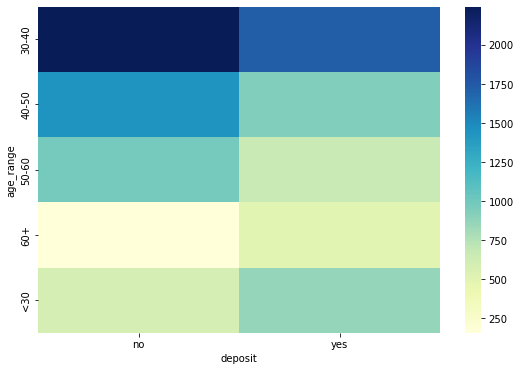

In [999]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_range(x):
  if x < 30:
    return '<30'
  elif x >= 30 and x < 40:
    return '30-40'
  elif x >= 40 and x < 50:
    return '40-50'
  elif x >= 50 and x < 60:
    return '50-60'
  else:
    return '60+'

df['age_range'] = df['age'].apply(age_range)

age_grouped = df.groupby('age_range')['deposit'].value_counts().unstack()
fig = plt.figure(figsize=(9, 6))
sns.heatmap(data=age_grouped, cmap='YlGnBu')

In [1000]:
import plotly
import plotly.express as px
print(plotly.__version__)

age_grouped2 = df.groupby('age_range')['deposit'].value_counts().unstack()
fig = px.line(
    data_frame=age_grouped2,
    height=500, 
    width=900,
    title='Age range and deposit'
)
fig.show()

5.8.0


In [1001]:
age_grouped3 = df.groupby('age_range')['deposit'].value_counts().unstack().reset_index()
age_grouped3['ratio'] = age_grouped3['yes'] / age_grouped3['no']
age_grouped3

deposit,age_range,no,yes,ratio
0,30-40,2245,1716,0.764365
1,40-50,1444,938,0.649584
2,50-60,984,670,0.680894
3,60+,157,496,3.159236
4,<30,594,861,1.449495


### Задания 9 и 10

In [1003]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital_grouped = df.groupby('marital')['deposit'].value_counts().unstack()
fig = px.line(
    data_frame=marital_grouped,
    height=500, 
    width=900,
    title='Marital and deposit'
)
fig.show()

In [1004]:
fig = px.bar(
    marital_grouped,
    height=500, 
    width=900,
    title='Marital and deposit')
fig.show()

In [1006]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
education_grouped = df.groupby('education')['deposit'].value_counts().unstack()
fig = px.line(
    data_frame=education_grouped,
    height=500, 
    width=900,
    title='Education and deposit'
)
fig.show()

In [1007]:
fig = px.bar(
    education_grouped,
    height=500, 
    width=900,
    title='Education and deposit')
fig.show()

In [1008]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job_grouped = df.groupby('job')['deposit'].value_counts().unstack()
fig = px.line(
    data_frame=job_grouped,
    height=500, 
    width=900,
    title='Job and deposit'
)
fig.show()

In [1009]:
fig = px.bar(
    job_grouped,
    height=500, 
    width=900,
    title='Job and deposit')
fig.show()

### Задание 11

In [1010]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_deposit_yes = df[df['deposit']=='yes']
df_deposit_no = df[df['deposit']=='no']

grouped_1 = df_deposit_yes.groupby(by='marital')['education'].value_counts().unstack()
fig1 = px.bar(
    grouped_1,
    height=500, 
    width=900,
    title='Deposit YES - Marital and Education')
fig1.show()

grouped_2 = df_deposit_no.groupby(by='marital')['education'].value_counts().unstack()
fig1 = px.bar(
    grouped_1,
    height=500, 
    width=900,
    title='Deposit NO - Marital and Education')
fig1.show()

Text(0.5, 1.0, 'Deposit NO - Marital and Education')

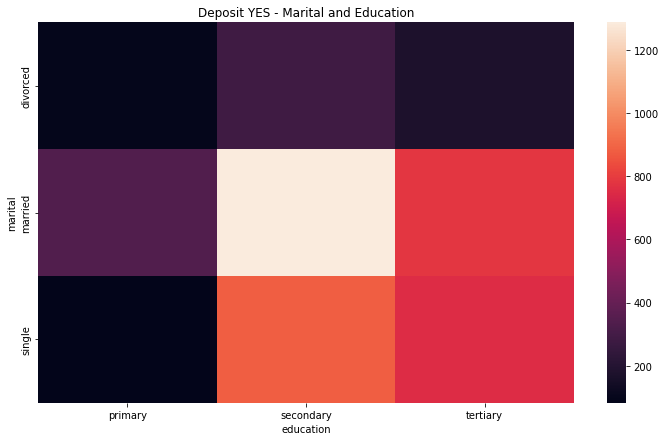

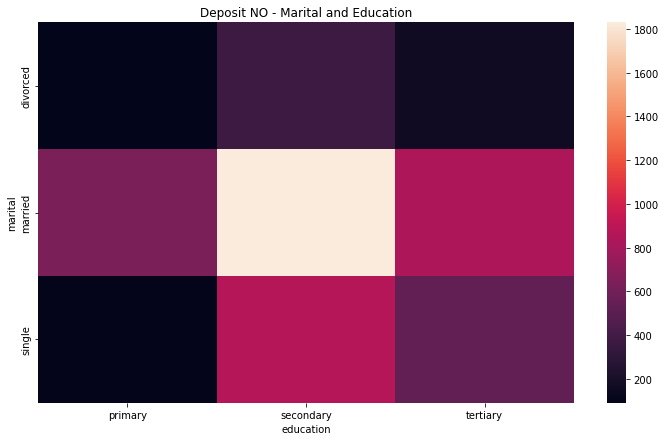

In [1011]:
fig1 = plt.figure(figsize=(12, 7))
fig1 = sns.heatmap(grouped_1)
fig1.set_title('Deposit YES - Marital and Education')

fig2 = plt.figure(figsize=(12, 7))
fig2 = sns.heatmap(grouped_2)
fig2.set_title('Deposit NO - Marital and Education')

## Часть 3: преобразование данных

### Задание 1

In [1012]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['education'])
df['education'] = le.transform(df['education'])

df['education'].sum()

11995

### Задания 2 и 3

In [ ]:
# преобразуйте бинарные переменные в представление из нулей и единиц

### Задание 4

In [ ]:
# создайте дамми-переменные

### Задания 5 и 6

In [ ]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

### Задания 7 и 8

In [3]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [ ]:
# рассчитайте необходимые показатели

### Задание 9

In [ ]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [4]:
# обучите на ваших данных случайный лес

### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

### Задание 5

In [ ]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna